## Aleatoric UQ for PtychoNN
Using Kendall and Gal's approach: https://proceedings.neurips.cc/paper/2017/hash/2650d6089a6d640c5e85b2b88265dc2b-Abstract.html

Implemented in 1D here: https://github.com/mcherukara/UQ_NNs

In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
from skimage.transform import resize

import matplotlib.pyplot as plt
import matplotlib

import os
os.environ["CUDA_VISIBLE_DEVICES"]="6,7"

from sklearn.utils import shuffle

torch.__version__

/home/mcherukara/miniconda3/envs/PyTorch1.11/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.11.0'

In [2]:
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
plt.viridis()

<Figure size 432x288 with 0 Axes>

In [3]:
def plot3(data,titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3"]
    fig,ax = plt.subplots(1,3, figsize=(20,12))
    im=ax[0].imshow(data[0])
    ax[0].set_title(titles[0])
    ax[0].axis('off')
    plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
    im=ax[1].imshow(data[1])
    ax[1].set_title(titles[1])
    ax[1].axis('off')
    plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
    im=ax[2].imshow(data[2])
    ax[2].set_title(titles[2])
    ax[2].axis('off')
    plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)

In [4]:
EPOCHS = 24
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS * 32
LR = 1e-3 * NGPUS
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

GPUs: 2 Batch size: 64 Learning rate: 0.002


In [5]:
H,W = 64,64
NLINES = 100 #How many lines of data to use for training?
NLTEST = 60 #How many lines for the test set?

N_VALID = 805 #How much to reserve for validation

**Note that the "path" can be different for different directory structures. For example, the original code in train.ipynb contains a different path.**  

In [6]:
path = os.getcwd()

MODEL_SAVE_PATH = path +'/trained_model/'
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)

In [7]:
data_diffr = np.load('../../../data/20191008_39_diff.npz')['arr_0']#np.load(path+'/../data/20191008_39_diff.npz')['arr_0']
real_space = np.load('../../../data/20191008_39_amp_pha_10nm_full.npy')#np.load(path+'/../data/20191008_39_amp_pha_10nm_full.npy')

amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

In [8]:
try:
    data_diffr_red = np.load('../../../data/20191008_39_diff_reduced.npz')['arr_0']
except:
    print(data_diffr.shape)

    data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), dtype=float)
    for i in tqdm(range(data_diffr.shape[0])):
        for j in range(data_diffr.shape[1]):
            data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
            data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])
    np.savez_compressed('../../data/20191008_39_diff_reduced.npz', data_diffr_red)
data_diffr.shape, data_diffr_red.shape

((161, 161, 256, 256), (161, 161, 64, 64))

In [9]:
tst_strt = amp.shape[0]-NLTEST #Where to index from
print(tst_strt)

X_train = data_diffr_red[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_train = amp[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_train = ph[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

101
(16100, 1, 64, 64) (3600, 1, 64, 64)


In [10]:
#Training data
X_train_tensor = torch.Tensor(X_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 
Y_phi_train_tensor = torch.Tensor(Y_phi_train)

#Test data
X_test_tensor = torch.Tensor(X_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 
Y_phi_test_tensor = torch.Tensor(Y_phi_test)

print(Y_phi_train.max(), Y_phi_train.min())

print(X_train_tensor.shape, Y_I_train_tensor.shape, Y_phi_train_tensor.shape)

train_data = TensorDataset(X_train_tensor,Y_I_train_tensor,Y_phi_train_tensor)
test_data = TensorDataset(X_test_tensor)

3.1268637 -1.564053
torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64])


In [11]:
N_TRAIN = X_train_tensor.shape[0]
train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-N_VALID,N_VALID])
print(len(train_data2),len(valid_data),len(test_data))

15295 805 3600


In [12]:
#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [13]:
nconv = 16


class recon_model(nn.Module):

    def __init__(self):
        super(recon_model, self).__init__()


        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
          nn.Conv2d(in_channels=1, out_channels=nconv, kernel_size=3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv, nconv, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv*2, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),
          )

        self.decoder1 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 2, 3, stride=1, padding=(1,1)), #Output conv layer has 2 for mu and sigma
          nn.Sigmoid() #Amplitude model
          )

        self.decoder2 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 2, 3, stride=1, padding=(1,1)), #Output conv layer has 2 for mu and sigma
          nn.Tanh() #Phase model
          )
    
    def forward(self,x):
        with torch.cuda.amp.autocast():
            x1 = self.encoder(x)
            amp = self.decoder1(x1)
            ph = self.decoder2(x1)

            #Restore -pi to pi range
            ph = ph*np.pi #Using tanh activation (-1 to 1) for phase so multiply by pi

        return amp, ph#Return mu and sigma of amp and phase predicts

In [14]:
model = recon_model()
for ft_images,amps,phs in trainloader:
    print("batch size:", ft_images.shape)
    amp_train, ph_train = model(ft_images)
    print(amp_train.shape, ph_train.shape)
    print(amp_train.dtype, ph_train.dtype)
    break

batch size: torch.Size([64, 1, 64, 64])
torch.Size([64, 2, 64, 64]) torch.Size([64, 2, 64, 64])
torch.float32 torch.float32


In [15]:
summary(model,(1,H,W),device="cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model) #Default all devices

model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             160
              ReLU-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 16, 64, 64]           2,320
              ReLU-4           [-1, 16, 64, 64]               0
         MaxPool2d-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           4,640
              ReLU-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,248
              ReLU-9           [-1, 32, 32, 32]               0
        MaxPool2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          18,496
             ReLU-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,928
             ReLU-14           [-1, 64,

In [16]:
#Optimizer details
iterations_per_epoch = np.floor((N_TRAIN-N_VALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 number of iterations, step_size is half cycle
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))

optimizer = torch.optim.Adam(model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR / 10, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')

LR step size is: 1434.0 which is every 6 epochs


In [17]:
#Function to update saved model if validation loss is minimum
def update_saved_model(model, path):
    if not os.path.isdir(path):
        os.mkdir(path)
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
    if (NGPUS>1):    
        torch.save(model.module.state_dict(),path+'best_model.pth') #Have to save the underlying model else will always need 4 GPUs
    else:
        torch.save(model,path+'best_model.pth')

**For the "mixed precision" part we just modify the original code slightly to include the 'scaler' in the following code blocks**

In [18]:
scaler = torch.cuda.amp.GradScaler()

In [19]:
#More robust to predict the log variance (regularizer)
def aleatoric_loss(y_pred, y_true):
    mu_pred = y_pred[:,0].unsqueeze(1)#First axis are the predicted means
    sigma_pred = y_pred[:,1].unsqueeze(1)#Second axis are the predicted log variance
    #y_true shape is batch, 1, H, W
    #print(y_true.shape, mu_pred.shape, sigma_pred.shape)
    se = (y_true-mu_pred)**2 
    inv_std = torch.exp(-sigma_pred) 
    mse = torch.mean(inv_std*se) #1/2*exp(-s)*|y-y_pred|**2
    reg = torch.mean(sigma_pred) #1/2*s term
    return 0.5*(mse + reg)

In [20]:
def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    loss_ph = 0.0
    
    for i, (ft_images,amps,phs) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        phs = phs.to(device)

        pred_amps, pred_phs = model(ft_images) #Forward pass

        #Compute losses
        loss_a = aleatoric_loss(pred_amps,amps) #Monitor amplitude loss
        loss_p = aleatoric_loss(pred_phs,phs) #Monitor phase loss
        loss = loss_a + loss_p #Use equiweighted amps and phase
        
        
        #Zero current grads and do backprop
        optimizer.zero_grad() 
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        #optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()
        loss_ph += loss_p.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        scaler.update()
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i,loss_ph/i]) 
    

def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    val_loss_ph = 0.0
    for j, (ft_images,amps,phs) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        phs = phs.to(device)
        pred_amps, pred_phs = model(ft_images) #Forward pass
    
    
        val_loss_a = aleatoric_loss(pred_amps,amps) 
        val_loss_p = aleatoric_loss(pred_phs,phs)
        val_loss = val_loss_a + val_loss_p
           
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
        val_loss_ph += val_loss_p.detach().item()  
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j,val_loss_ph/j])
  
  #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH)

In [21]:
metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf}

In [22]:

for epoch in range (EPOCHS):
    
  #Set model to train mode
  model.train() 
    
  #Training loop
  train(trainloader,metrics)

    
  #Switch model to eval mode
  model.eval()
    
  #Validation loop
  validate(validloader,metrics)
  
  print('Epoch: %d | FT  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
  print('Epoch: %d | Amp | Train Loss: %.4f | Val Loss: %.4f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
  print('Epoch: %d | Ph  | Train Loss: %.3f | Val Loss: %.3f' %(epoch, metrics['losses'][-1][2], metrics['val_losses'][-1][2]))
  print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

0it [00:00, ?it/s]/home/mcherukara/miniconda3/envs/PyTorch1.11/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
239it [00:08, 27.90it/s]


Saving improved model after Val Loss improved from inf to 0.16683
Epoch: 0 | FT  | Train Loss: 0.31756 | Val Loss: 0.16683
Epoch: 0 | Amp | Train Loss: 0.0226 | Val Loss: 0.0042
Epoch: 0 | Ph  | Train Loss: 0.295 | Val Loss: 0.163
Epoch: 0 | Ending LR: 0.000500 


239it [00:04, 50.82it/s]


Saving improved model after Val Loss improved from 0.16683 to -0.03321
Epoch: 1 | FT  | Train Loss: 0.08336 | Val Loss: -0.03321
Epoch: 1 | Amp | Train Loss: 0.0038 | Val Loss: 0.0041
Epoch: 1 | Ph  | Train Loss: 0.080 | Val Loss: -0.037
Epoch: 1 | Ending LR: 0.000800 


239it [00:04, 49.38it/s]


Saving improved model after Val Loss improved from -0.03321 to -0.20363
Epoch: 2 | FT  | Train Loss: -0.09625 | Val Loss: -0.20363
Epoch: 2 | Amp | Train Loss: 0.0014 | Val Loss: 0.0004
Epoch: 2 | Ph  | Train Loss: -0.098 | Val Loss: -0.204
Epoch: 2 | Ending LR: 0.001100 


239it [00:04, 49.27it/s]


Saving improved model after Val Loss improved from -0.20363 to -0.30941
Epoch: 3 | FT  | Train Loss: -0.22671 | Val Loss: -0.30941
Epoch: 3 | Amp | Train Loss: 0.0004 | Val Loss: 0.0003
Epoch: 3 | Ph  | Train Loss: -0.227 | Val Loss: -0.310
Epoch: 3 | Ending LR: 0.001400 


239it [00:04, 48.87it/s]


Saving improved model after Val Loss improved from -0.30941 to -0.36409
Epoch: 4 | FT  | Train Loss: -0.31947 | Val Loss: -0.36409
Epoch: 4 | Amp | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch: 4 | Ph  | Train Loss: -0.320 | Val Loss: -0.364
Epoch: 4 | Ending LR: 0.001700 


239it [00:04, 50.62it/s]


Saving improved model after Val Loss improved from -0.36409 to -0.39565
Epoch: 5 | FT  | Train Loss: -0.36433 | Val Loss: -0.39565
Epoch: 5 | Amp | Train Loss: 0.0002 | Val Loss: 0.0001
Epoch: 5 | Ph  | Train Loss: -0.364 | Val Loss: -0.396
Epoch: 5 | Ending LR: 0.002000 


239it [00:04, 49.81it/s]


Saving improved model after Val Loss improved from -0.39565 to -0.53136
Epoch: 6 | FT  | Train Loss: -0.45398 | Val Loss: -0.53136
Epoch: 6 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 6 | Ph  | Train Loss: -0.454 | Val Loss: -0.531
Epoch: 6 | Ending LR: 0.001700 


239it [00:04, 49.36it/s]


Saving improved model after Val Loss improved from -0.53136 to -0.56498
Epoch: 7 | FT  | Train Loss: -0.55074 | Val Loss: -0.56498
Epoch: 7 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 7 | Ph  | Train Loss: -0.551 | Val Loss: -0.565
Epoch: 7 | Ending LR: 0.001400 


239it [00:04, 48.75it/s]


Saving improved model after Val Loss improved from -0.56498 to -0.65907
Epoch: 8 | FT  | Train Loss: -0.61981 | Val Loss: -0.65907
Epoch: 8 | Amp | Train Loss: 0.0000 | Val Loss: 0.0001
Epoch: 8 | Ph  | Train Loss: -0.620 | Val Loss: -0.659
Epoch: 8 | Ending LR: 0.001100 


239it [00:04, 50.44it/s]


Saving improved model after Val Loss improved from -0.65907 to -0.73670
Epoch: 9 | FT  | Train Loss: -0.70356 | Val Loss: -0.73670
Epoch: 9 | Amp | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch: 9 | Ph  | Train Loss: -0.704 | Val Loss: -0.737
Epoch: 9 | Ending LR: 0.000800 


239it [00:04, 48.62it/s]


Saving improved model after Val Loss improved from -0.73670 to -0.79942
Epoch: 10 | FT  | Train Loss: -0.77553 | Val Loss: -0.79942
Epoch: 10 | Amp | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch: 10 | Ph  | Train Loss: -0.776 | Val Loss: -0.799
Epoch: 10 | Ending LR: 0.000500 


239it [00:05, 47.68it/s]


Saving improved model after Val Loss improved from -0.79942 to -0.84701
Epoch: 11 | FT  | Train Loss: -0.84641 | Val Loss: -0.84701
Epoch: 11 | Amp | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch: 11 | Ph  | Train Loss: -0.846 | Val Loss: -0.847
Epoch: 11 | Ending LR: 0.000200 


239it [00:04, 50.70it/s]


Saving improved model after Val Loss improved from -0.84701 to -0.84824
Epoch: 12 | FT  | Train Loss: -0.88301 | Val Loss: -0.84824
Epoch: 12 | Amp | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch: 12 | Ph  | Train Loss: -0.883 | Val Loss: -0.848
Epoch: 12 | Ending LR: 0.000350 


239it [00:04, 48.20it/s]


Epoch: 13 | FT  | Train Loss: -0.87485 | Val Loss: -0.83042
Epoch: 13 | Amp | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch: 13 | Ph  | Train Loss: -0.875 | Val Loss: -0.830
Epoch: 13 | Ending LR: 0.000500 


239it [00:04, 49.39it/s]


Epoch: 14 | FT  | Train Loss: -0.86504 | Val Loss: -0.81688
Epoch: 14 | Amp | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch: 14 | Ph  | Train Loss: -0.865 | Val Loss: -0.817
Epoch: 14 | Ending LR: 0.000650 


239it [00:04, 48.82it/s]


Epoch: 15 | FT  | Train Loss: -0.84625 | Val Loss: -0.82918
Epoch: 15 | Amp | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch: 15 | Ph  | Train Loss: -0.846 | Val Loss: -0.829
Epoch: 15 | Ending LR: 0.000800 


239it [00:04, 50.68it/s]


Epoch: 16 | FT  | Train Loss: -0.81431 | Val Loss: -0.80255
Epoch: 16 | Amp | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch: 16 | Ph  | Train Loss: -0.814 | Val Loss: -0.803
Epoch: 16 | Ending LR: 0.000950 


239it [00:04, 49.60it/s]


Epoch: 17 | FT  | Train Loss: -0.80085 | Val Loss: -0.76966
Epoch: 17 | Amp | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch: 17 | Ph  | Train Loss: -0.801 | Val Loss: -0.770
Epoch: 17 | Ending LR: 0.001100 


239it [00:04, 48.20it/s]


Epoch: 18 | FT  | Train Loss: -0.82217 | Val Loss: -0.82074
Epoch: 18 | Amp | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch: 18 | Ph  | Train Loss: -0.822 | Val Loss: -0.821
Epoch: 18 | Ending LR: 0.000950 


239it [00:04, 48.23it/s]


Saving improved model after Val Loss improved from -0.84824 to -0.87877
Epoch: 19 | FT  | Train Loss: -0.87840 | Val Loss: -0.87877
Epoch: 19 | Amp | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch: 19 | Ph  | Train Loss: -0.878 | Val Loss: -0.879
Epoch: 19 | Ending LR: 0.000800 


239it [00:04, 49.31it/s]


Saving improved model after Val Loss improved from -0.87877 to -0.91031
Epoch: 20 | FT  | Train Loss: -0.92036 | Val Loss: -0.91031
Epoch: 20 | Amp | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch: 20 | Ph  | Train Loss: -0.920 | Val Loss: -0.910
Epoch: 20 | Ending LR: 0.000650 


239it [00:04, 49.77it/s]


Saving improved model after Val Loss improved from -0.91031 to -0.92252
Epoch: 21 | FT  | Train Loss: -0.96202 | Val Loss: -0.92252
Epoch: 21 | Amp | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch: 21 | Ph  | Train Loss: -0.962 | Val Loss: -0.923
Epoch: 21 | Ending LR: 0.000500 


239it [00:04, 49.71it/s]


Saving improved model after Val Loss improved from -0.92252 to -0.94734
Epoch: 22 | FT  | Train Loss: -1.00542 | Val Loss: -0.94734
Epoch: 22 | Amp | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch: 22 | Ph  | Train Loss: -1.005 | Val Loss: -0.947
Epoch: 22 | Ending LR: 0.000350 


239it [00:04, 48.49it/s]


Saving improved model after Val Loss improved from -0.94734 to -0.97148
Epoch: 23 | FT  | Train Loss: -1.03968 | Val Loss: -0.97148
Epoch: 23 | Amp | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch: 23 | Ph  | Train Loss: -1.040 | Val Loss: -0.972
Epoch: 23 | Ending LR: 0.000200 


Text(0.5, 0, 'Epoch')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


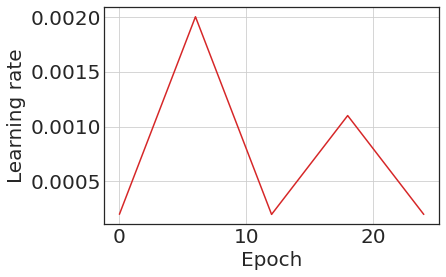

In [23]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")

Text(0.5, 45.5, 'Epochs')

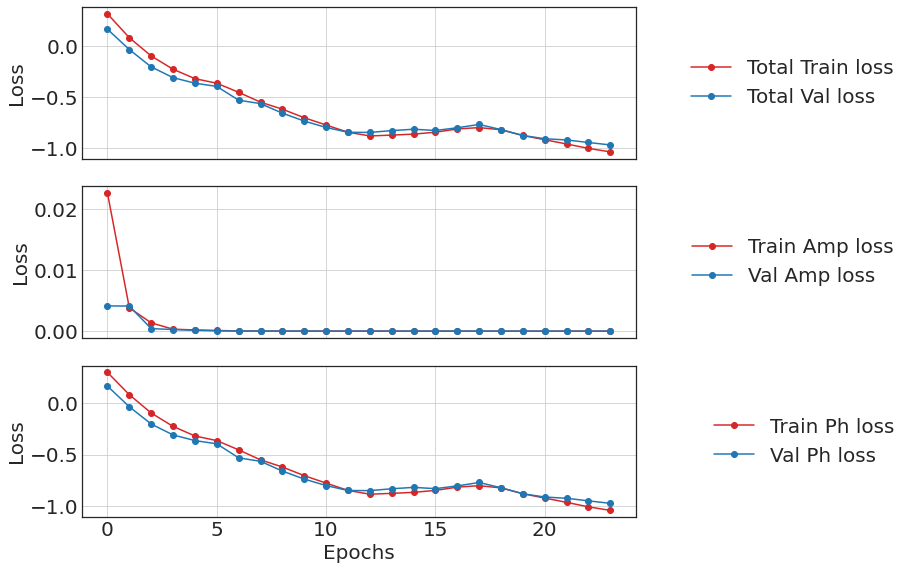

In [24]:
losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(3,sharex=True, figsize=(15, 8))
ax[0].plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax[0].plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax[0].set(ylabel='Loss')
ax[0].grid()
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[1].plot(losses_arr[:,1], 'C3o-', label = "Train Amp loss")
ax[1].plot(val_losses_arr[:,1], 'C0o-', label = "Val Amp loss")
ax[1].set(ylabel='Loss')
ax[1].grid()
ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[2].plot(losses_arr[:,2], 'C3o-', label = "Train Ph loss")
ax[2].plot(val_losses_arr[:,2], 'C0o-', label = "Val Ph loss")
ax[2].set(ylabel='Loss')
ax[2].grid()
ax[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.tight_layout()
plt.xlabel("Epochs")

In [25]:
model.eval() #imp when have dropout etc
amps_preds = []
phs_preds = []
for i, ft_images in enumerate(testloader):
    ft_images = ft_images[0].to(device)
    amp_eval, ph_eval = model(ft_images)
    for j in range(ft_images.shape[0]):
        amps_preds.append(amp_eval[j].detach().to("cpu").numpy())
        phs_preds.append(ph_eval[j].detach().to("cpu").numpy())

amps_preds = np.array(amps_preds).squeeze()
phs_preds = np.array(phs_preds).squeeze()
print(amps_preds.shape, amps_preds.dtype)
print(phs_preds.shape, phs_preds.dtype)

(3600, 2, 64, 64) float16
(3600, 2, 64, 64) float16


In [39]:
#Get the means
amps_eval = amps_preds[:,0,:,:]
phs_eval = phs_preds[:,0,:,:]

#Get the stds
amps_aleatoric_std = np.exp(0.5*amps_preds[:,1,:,:])
phs_aleatoric_std = np.exp(0.5*phs_preds[:,1,:,:]) #Output is log variance, so take exp here


## Plot the single shot predictions

<Figure size 432x288 with 0 Axes>

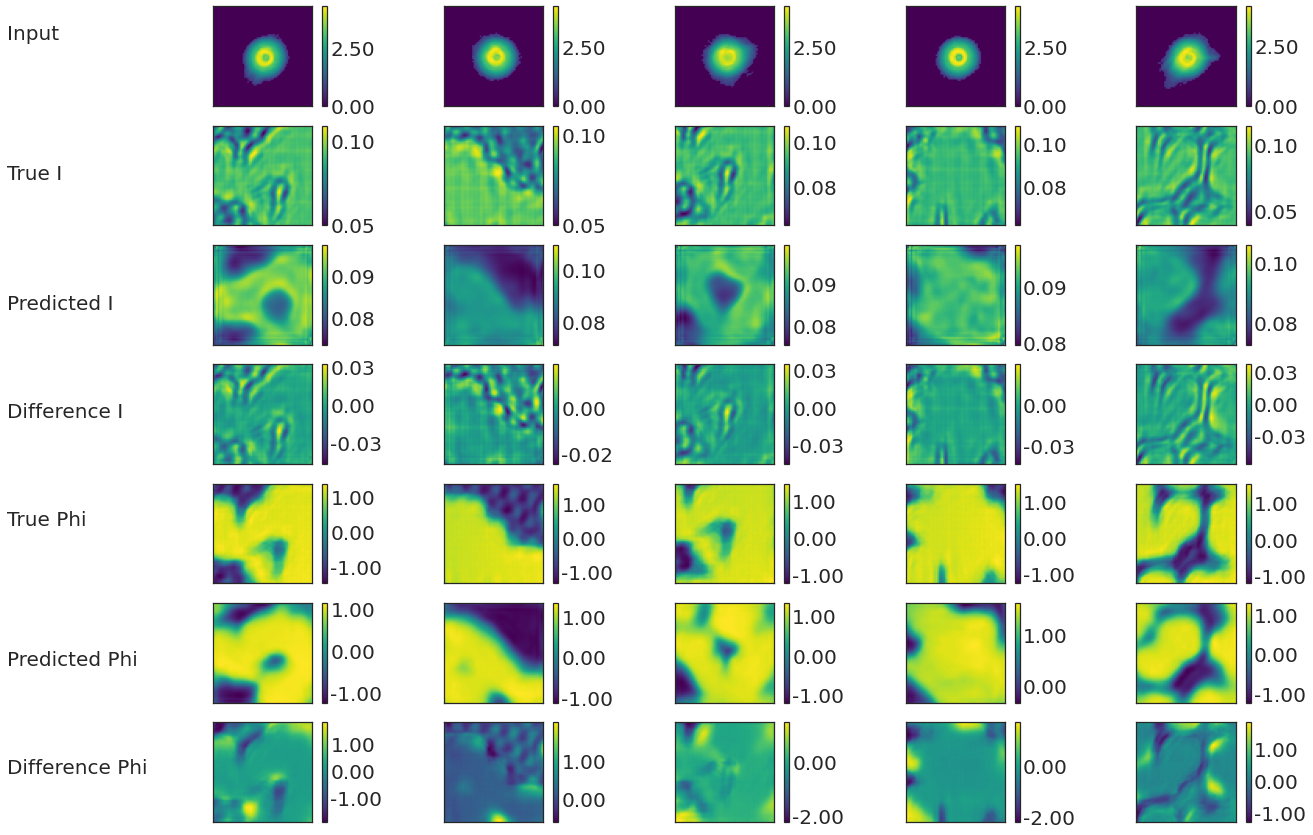

In [40]:
h,w = 64,64
ntest=amps_eval.shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT

    im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    
    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(amps_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(phs_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    
    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w) - amps_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w) - phs_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()

## Plot the single shot uncertainties

<Figure size 432x288 with 0 Axes>

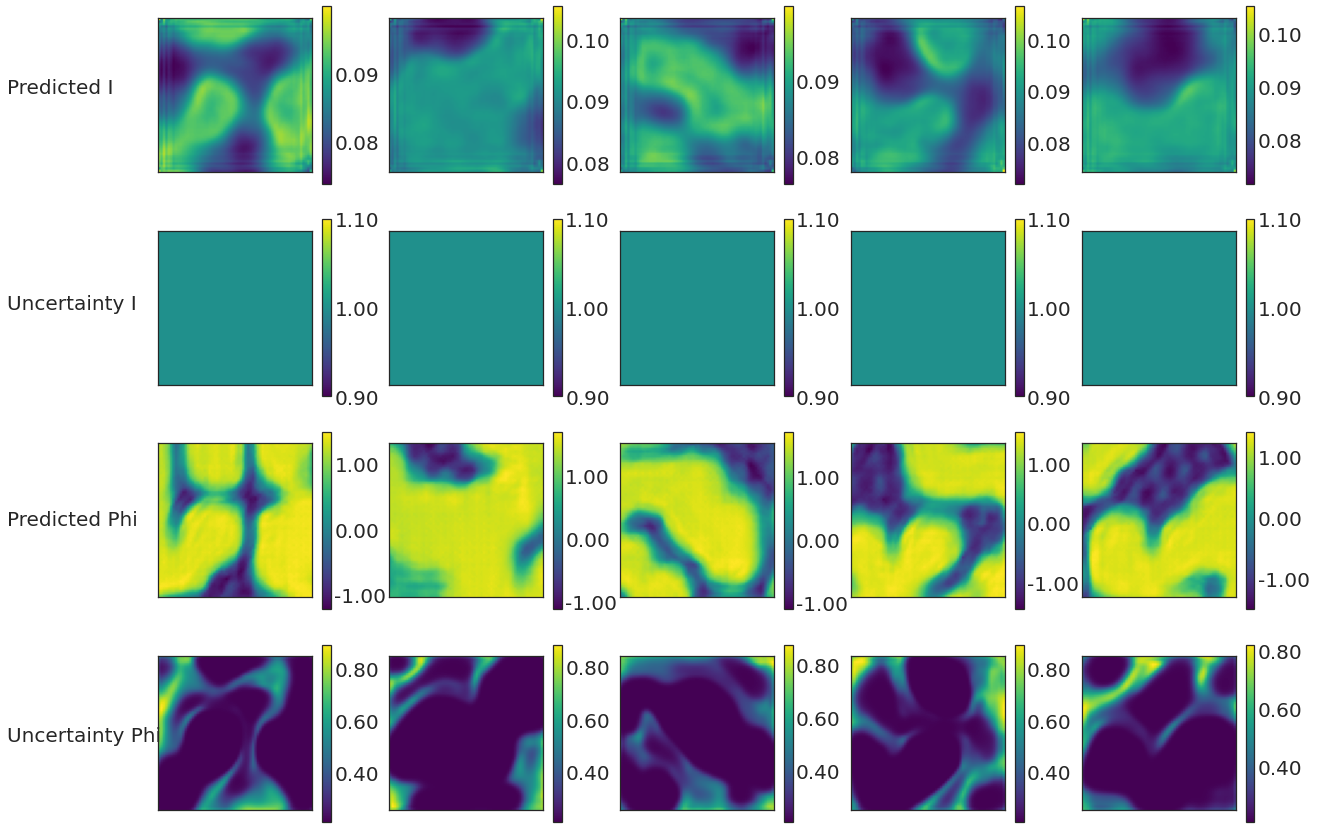

In [41]:
h,w = 64,64
ntest=amps_eval.shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(4,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.8, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Uncertainty I", fontsize=20)
plt.gcf().text(0.02, 0.4, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.2, "Uncertainty Phi", fontsize=20)


for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

    # display predicted intens
    im=ax[0,i].imshow(amps_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    
    # display uncertainty intens
    im=ax[1,i].imshow(amps_aleatoric_std[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[2,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
    # display uncertainty phase
    im=ax[3,i].imshow(phs_aleatoric_std[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    
plt.show()

In [42]:
def stitcher(arr):
    tst_side = 60
    point_size = 3
    overlap = 4*point_size

    composite = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
    ctr = np.zeros_like(composite)
    data_reshaped = arr.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                        32-int(overlap/2):32+int(overlap/2)]

    for i in range(tst_side):
        for j in range(tst_side):
            composite[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
            ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

    stitched = composite[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

    stitched_down = resize(stitched, (tst_side,tst_side), preserve_range=True, anti_aliasing=True)
    return stitched_down



In [43]:
stitched_amp_down = stitcher(amps_eval)
stitched_phase_down = stitcher(phs_eval)
stitched_phase_ale = stitcher(phs_aleatoric_std)
stitched_amp_ale = stitcher(amps_aleatoric_std)


In [44]:
true_amp = Y_I_test.reshape(NLTEST,NLTEST,64,64)
true_ph = Y_phi_test.reshape(NLTEST,NLTEST,64,64)

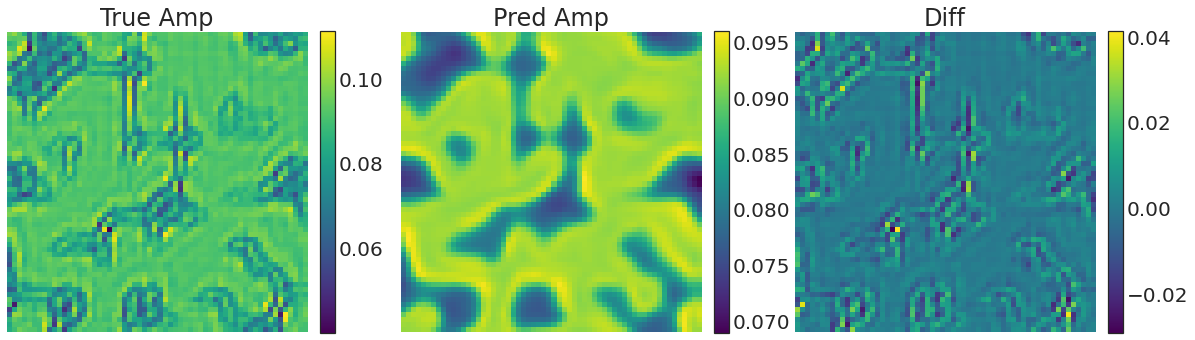

In [45]:
plot3([true_amp[:,:,32,32],stitched_amp_down,stitched_amp_down-true_amp[:,:,32,32]],["True Amp", "Pred Amp", "Diff"])

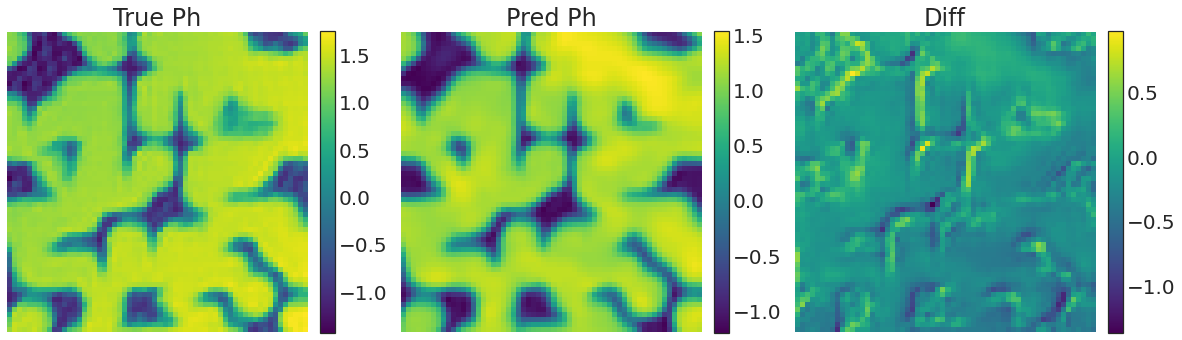

In [46]:
plot3([true_ph[:,:,32,32],stitched_phase_down,stitched_phase_down-true_ph[:,:,32,32]],["True Ph", "Pred Ph", "Diff"])

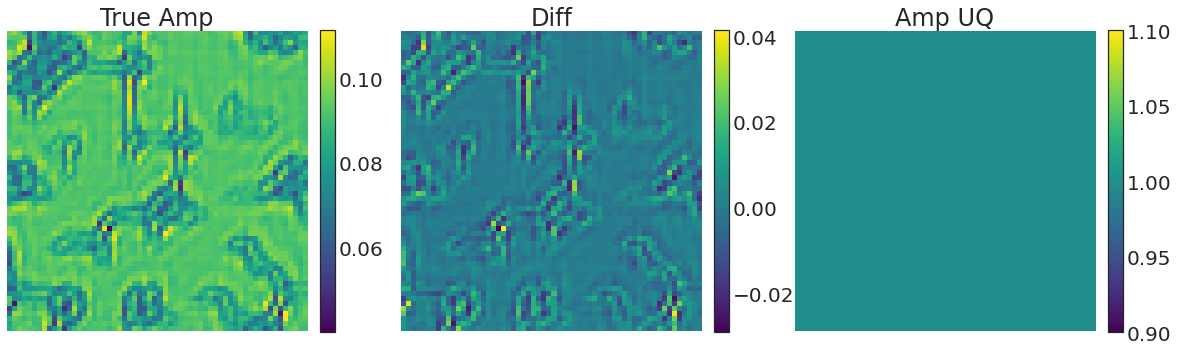

In [47]:
plot3([true_amp[:,:,32,32],stitched_amp_down-true_amp[:,:,32,32],stitched_amp_ale],["True Amp", "Diff", "Amp UQ"])

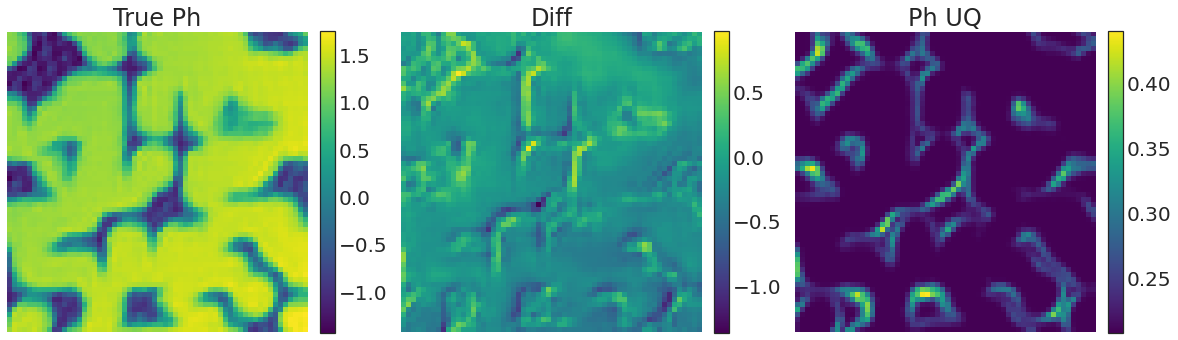

In [48]:
plot3([true_ph[:,:,32,32],stitched_phase_down-true_ph[:,:,32,32],stitched_phase_ale],["True Ph", "Diff", "Ph UQ"])

In [49]:
from sklearn.metrics import mean_squared_error as mse
from skimage.registration import phase_cross_correlation
print ("MSE in amplitude: ", mse(stitched_amp_down, true_amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, true_ph[:,:,32,32]))

MSE in amplitude:  4.93903031125733e-05
MSE in phase:  0.07826003135143414


In [37]:
true_img = true_amp * np.exp(1j * true_ph)
stitched_img = stitched_amp_down * np.exp(1j * stitched_phase_down)

In [38]:
_roll, _err, _phase = phase_cross_correlation(true_img[:,:,32, 32], stitched_img)
phase_cross_correlation(true_img[:,:,32,32], stitched_img * np.exp(1j * _phase))

(array([0., 0.]), 0.9998946141607923, -5.077003902180485e-16)